# Percolation keras

## initializations

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [3]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

tensorflow:  2.0.0 , keras:  2.3.1
sklearn:  0.22.1


Using TensorFlow backend.


In [4]:
import numpy as np
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 
from keras.models import Sequential
import keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Conv1D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os

## starting the main code

In [5]:
myseed = 123467

np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [6]:
img_sizeX= 100
img_sizeY= 100 #img_sizeX
validation_split= 0.1

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16
num_classes=2

dataname = 'Percolation_desktop'
datapath = '../'+dataname
modelname = '/model_'+dataname+'.h5'
modelpath = datapath+modelname


In [8]:
training_set = train_datagen.flow_from_directory('training_set_1000',
                                                 subset='training',
                                                 target_size = (100, 100),
                                                 batch_size = batch_size, 
                                                 class_mode='binary',
                                                shuffle=True)




validation_set= train_datagen.flow_from_directory('training_set_1000', 
                                              subset='validation', 
                                              target_size = (100, 100),
                                              batch_size = batch_size,
                                              class_mode='binary',
                                                 shuffle=False)

Found 9001 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


In [9]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

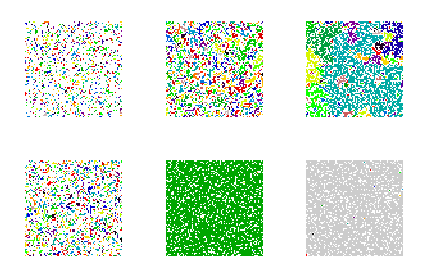

In [10]:
#plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

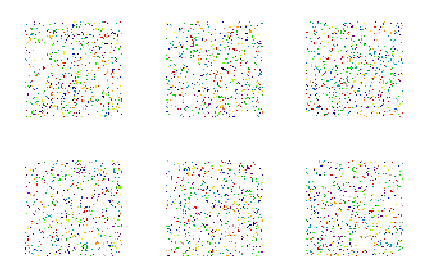

In [11]:
#plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
def create_CNN():
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(5,5),input_shape=(img_sizeX, img_sizeY, 3),
                activation = 'relu',  padding='valid'))
    model.add(Conv2D(16, kernel_size=(5,5),activation = 'relu',
                  padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2), padding='same'))

    model.add(Dropout(0.5))
               
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu', 
                 padding='valid'))  
    model.add(Conv2D(32,kernel_size=(3,3), activation = 'relu',
                 padding='same')) 
                 
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same')) 
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(5,5),input_shape=(100, 100, 3),
                activation = 'relu',  padding='valid'))
    model.add(Conv2D(64, kernel_size=(5,5),activation = 'relu',padding='same'))
    model.add(MaxPooling2D(pool_size =(2, 2),padding='same'))
                  
    model.add(Dropout(0.5))


    model.add(Flatten())
                             
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))                 
               
    return model

print('CNN architecture (Ohtsuki) created successfully!')

CNN architecture (Ohtsuki) created successfully!


In [13]:
# #from keras.optimizers import SGD
# opt1 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6)
# opt2=tf.keras.optimizers.Adam(lr=0.00001, decay=1e-6)
# opt3=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
# model.compile(optimizer = opt3, loss = 'binary_crossentropy', metrics = ['accuracy'])
# history = model.fit_generator(training_set,
#                          steps_per_epoch = training_set.samples// batch_size,
#                          epochs = 5,
#                          validation_data = validation_set,
#                          validation_steps = validation_set.samples// batch_size)

In [14]:
mylr=1.0 
mywd=1e-6
rho=0.95
# Choose the Optimizer and the Cost Function

# opt = optimizers.SGD(lr=mylr, decay=mywd)
opt1 = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6)
opt2=tf.keras.optimizers.Adam(lr=0.00001, decay=1e-6)
opt3=tf.keras.optimizers.Adadelta(learning_rate=mylr, rho=rho)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt3):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [15]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0

## learning the images

In [16]:
# training parameters
myepochs=10

In [17]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/10
562/562 [==============================] - 17s 31ms/step - loss: 0.3612 - accuracy: 0.8436 - val_loss: 0.1143 - val_accuracy: 0.9950
Epoch 2/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1700 - accuracy: 0.9269 - val_loss: 0.3919 - val_accuracy: 0.8649
Epoch 3/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1453 - accuracy: 0.9382 - val_loss: 0.1485 - val_accuracy: 0.9889
Epoch 4/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1316 - accuracy: 0.9417 - val_loss: 0.0823 - val_accuracy: 0.9798
Epoch 5/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1277 - accuracy: 0.9452 - val_loss: 0.0870 - val_accuracy: 0.9919
Epoch 6/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1197 - accuracy: 0.9477 - val_loss: 0.0691 - val_accuracy: 0.9919
Epoch 7/10
562/562 [==============================] - 16s 28ms/step - loss: 0.1176 - accuracy: 0.9499 - val_loss: 0.2505 - val_accuracy:

In [18]:
# model.save('Percolation_spanning_sgd_01_copy.h5') 
model.save(modelpath)

## testing the quality of the learned model

63/63 [==============================] - 1s 22ms/step - loss: 0.1429 - accuracy: 0.9409

Test loss: 0.1428948411235719
Test accuracy: 0.9409409


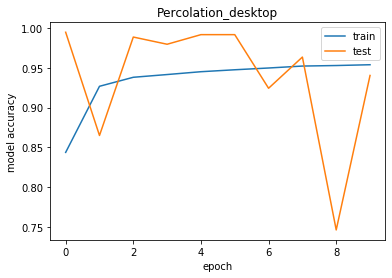

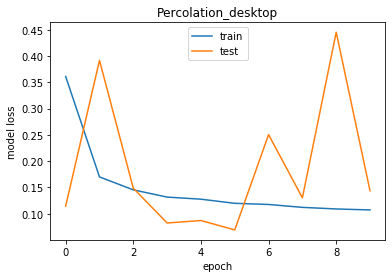

In [19]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_loss'+'.png')

In [20]:
num_of_train_samples = training_set.samples
num_of_test_samples =validation_set.samples

validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred =model.predict_generator(validation_set,validation_set.samples // batch_size+1, verbose=1)
y_pred=(Y_pred > 0.5).astype(int)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

63/63 [==============================] - 1s 23ms/step


array([[552,   0],
       [ 59, 388]])

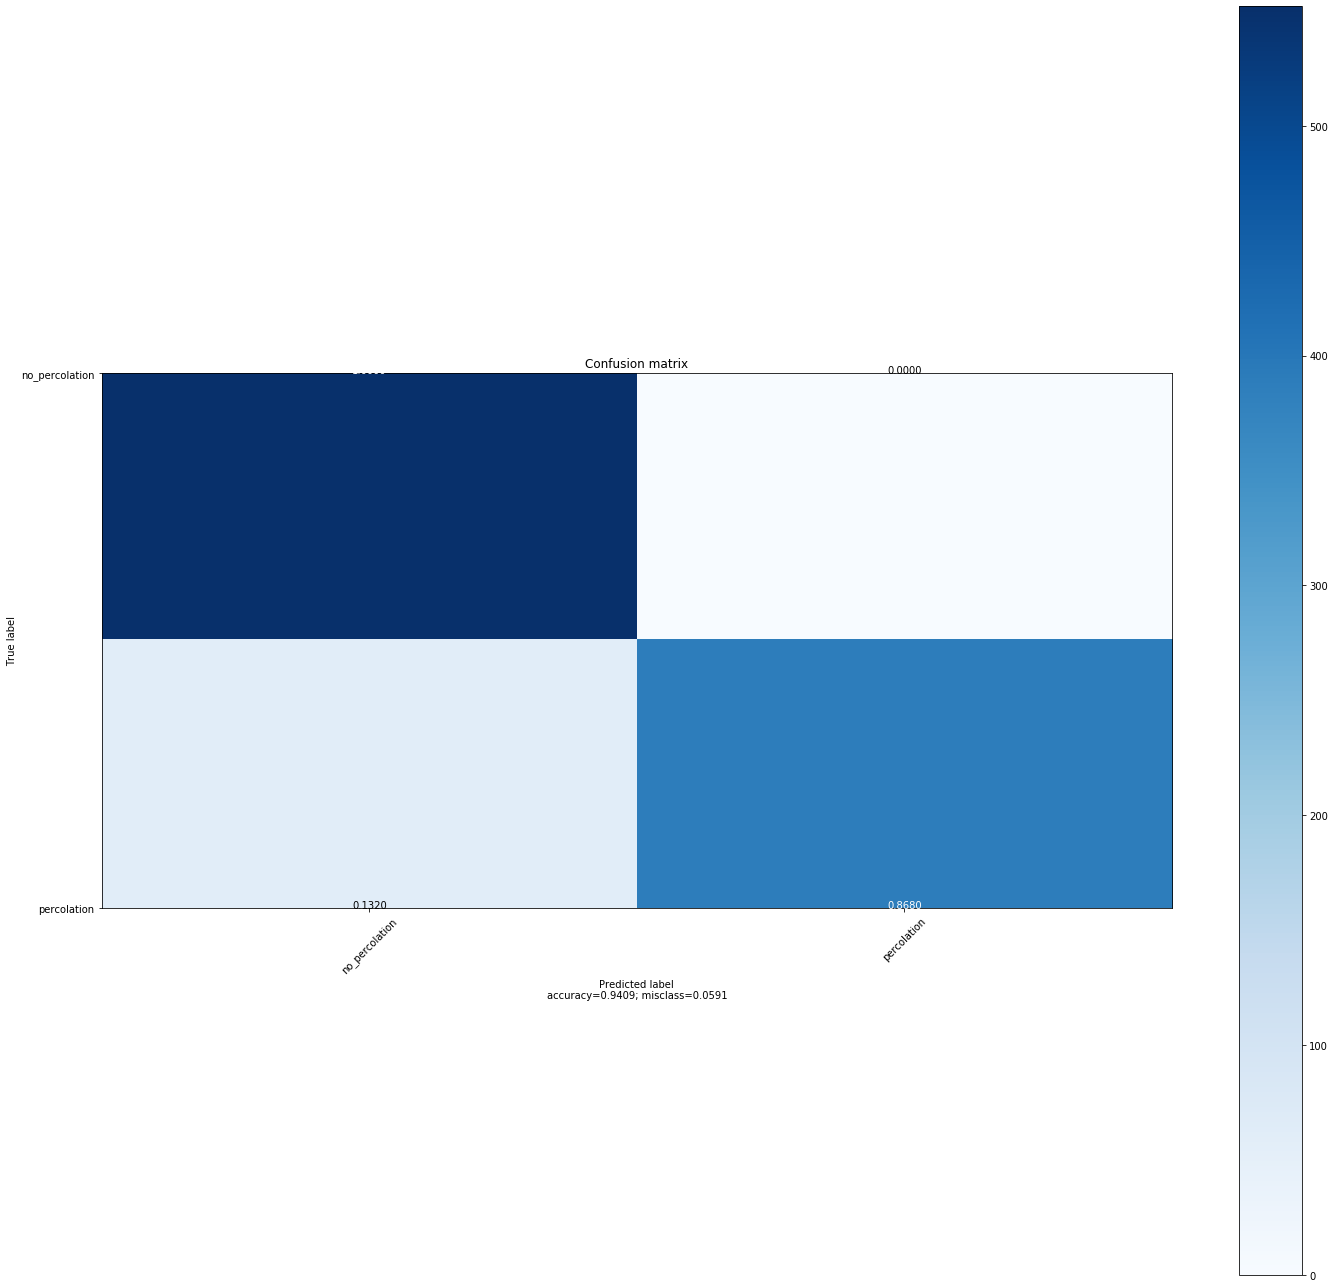

None


In [21]:
from plot_confusion_matrix import *
label=validation_set.class_indices.keys()
print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True))

In [22]:
classification_report(validation_set.classes,y_pred)

'              precision    recall  f1-score   support\n\n           0       0.90      1.00      0.95       552\n           1       1.00      0.87      0.93       447\n\n    accuracy                           0.94       999\n   macro avg       0.95      0.93      0.94       999\nweighted avg       0.95      0.94      0.94       999\n'

## modify the Hyperparameters to Optimize Performance of the Model

In [23]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [24]:
X_train, X_labels = next(training_set)
Y_train, Y_labels = next(validation_set)
len(X_train),len(X_labels),len(Y_train),len(Y_labels)

(16, 16, 16, 16)

In [25]:
X_train

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1. 

In [26]:
# from scipy.sparse import issparse
# from keras.wrappers.scikit_learn import KerasClassifier

# class KerasClassifier(KerasClassifier):
#      """ adds sparse matrix handling using batch generator
#      """
     
#      def fit(self, x, y, **kwargs):
#          """ adds sparse matrix handling """
#          if not issparse(x):
#             return super().fit(x, y, **kwargs)
         
#          ############ adapted from KerasClassifier.fit   ######################   
#          if self.build_fn is None:
#                 self.model = self.__call__(**self.filter_sk_params(self.__call__))
#          elif not isinstance(self.build_fn, types.FunctionType):
#                 self.model = self.build_fn(
#                  **self.filter_sk_params(self.build_fn.__call__))
#          else:
#              self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
 
#          loss_name = self.model.loss
#          if hasattr(loss_name, '__name__'):
#              loss_name = loss_name.__name__
#          if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
#              y = to_categorical(y)
#          ### fit = fit_generator
#          fit_args = copy.deepcopy(self.filter_sk_params(Sequential.fit_generator))
#          fit_args.update(kwargs)
#          ############################################################
#          self.model.fit_generator(
#                      self.get_batch(x, y, self.sk_params["batch_size"]),
#                                          samples_per_epoch=x.shape[0],
#                                          **fit_args)                      
#          return self                               
 
#      def get_batch(self, x, y=None, batch_size=32):
#          """ batch generator to enable sparse input """
#          index = np.arange(x.shape[0])
#          start = 0
#          while True:
#              if start == 0 and y is not None:
#                  np.random.shuffle(index)
#              batch = index[start:start+batch_size]
#              if y is not None:
#                  yield x[batch].toarray(), y[batch]
#              else:
#                  yield x[batch].toarray()
#              start += batch_size
#              if start == x.shape[0]:
#                  start = 0
   
#      def predict_proba(self, x):
#          """ adds sparse matrix handling """
#          if not issparse(x):
#              return super().predict_proba(x)
             
#          preds = self.model.predict_generator(
#                      self.get_batch(x, None, self.sk_params["batch_size"]), 
#                                                 val_samples=x.shape[0])
#          return preds

In [27]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# define parameter dictionary
param_grid = dict(optimizer=optimizer)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,X_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 12 samples
4/1 [========================================================================================================================] - 0s 51ms/sample - loss: 0.7138 - accuracy: 0.0000e+00
Train on 12 samples
4/1 [========================================================================================================================] - 0s 52ms/sample - loss: 0.7171 - accuracy: 0.2500
Train on 12 samples
4/1 [========================================================================================================================] - 0s 25ms/sample - loss: 0.6779 - accuracy: 0.7500
Train on 12 samples
4/1 [========================================================================================================================] - 0s 22ms/sample - loss: 0.6977 - accuracy: 0.5000
Train on 12 samples
4/1 [========================================================================================================================] - 0s 22ms/sample - loss: 1.0109 - accuracy: 0.0000e+00
Tr

Best: 0.625000 using {'optimizer': 'Adamax'}
0.375000 (0.279508) with: {'optimizer': 'SGD'}
0.375000 (0.279508) with: {'optimizer': 'RMSprop'}
0.250000 (0.176777) with: {'optimizer': 'Adagrad'}
0.375000 (0.279508) with: {'optimizer': 'Adadelta'}
0.375000 (0.279508) with: {'optimizer': 'Adam'}
0.625000 (0.279508) with: {'optimizer': 'Adamax'}
0.562500 (0.207289) with: {'optimizer': 'Nadam'}
